<a href="https://colab.research.google.com/github/AlexeyProvorov/Generative/blob/master/ARC_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

arc_prize_2024_path = kagglehub.competition_download('arc-prize-2024')

print('Data source import complete.')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def resize_matrix(matrix, target_size=(10, 10)):
    """
    Приводит любую матрицу (квадратную или прямоугольную) к заданному размеру (target_size)
    с сохранением структуры данных путем масштабирования (интерполяции).

    Parameters:
    matrix (np.ndarray): исходная матрица любого размера (квадратная или прямоугольная)
    target_size (tuple): целевой размер, по умолчанию (10, 10)

    Returns:
    np.ndarray: матрица размера target_size
    """
    current_size = matrix.shape
    row_zoom = target_size[0] / current_size[0]
    col_zoom = target_size[1] / current_size[1]

    resized_matrix = zoom(matrix, (row_zoom, col_zoom))

    return resized_matrix

def reverse_resize_matrix(matrix, original_size):
    """
    Возвращает матрицу к её исходному размеру (original_size) путем обратного масштабирования.

    Parameters:
    matrix (np.ndarray): матрица, которую нужно восстановить
    original_size (tuple): исходный размер матрицы

    Returns:
    np.ndarray: матрица исходного размера
    """
    current_size = matrix.shape
    row_zoom = original_size[0] / current_size[0]
    col_zoom = original_size[1] / current_size[1]

    restored_matrix = zoom(matrix, (row_zoom, col_zoom))

    return restored_matrix

In [ ]:
import numpy as np
import random

def generate_random_matrix(min_size=1, max_size=32):
    """
    Генерирует матрицу случайного размера от min_size до max_size
    со значениями от 0 до 9.

    Parameters:
    min_size (int): минимальный размер матрицы
    max_size (int): максимальный размер матрицы

    Returns:
    np.ndarray: случайная матрица произвольного размера
    tuple: размеры сгенерированной матрицы
    """
    rows = random.randint(min_size, max_size)
    cols = random.randint(min_size, max_size)
    matrix = np.random.randint(0, 10, size=(rows, cols))  # Генерация значений от 0 до 9
    return matrix, (rows, cols)

def generate_dataset(num_matrices, min_size=1, max_size=32):
    """
    Генерирует набор данных из случайных матриц разных размеров.

    Parameters:
    num_matrices (int): количество матриц для генерации
    min_size (int): минимальный размер матрицы
    max_size (int): максимальный размер матрицы

    Returns:
    list of tuples: список сгенерированных матриц и их размеров
    """
    dataset = []
    for _ in range(num_matrices):
        matrix, size = generate_random_matrix(min_size, max_size)
        dataset.append((matrix, size))
    return dataset

# Генерация  матриц
num_matrices = 200000  # Количество матриц в наборе данных
dataset = generate_dataset(num_matrices)

# Набор данных сгенерирован


In [ ]:
from sklearn.model_selection import train_test_split

# Используем ранее сгенерированный dataset из матриц
# Нам нужно прогнать их через функцию, чтобы все изображения стали 32x32

def scale_to_size(matrix, target_size=(32, 32)):
    """
    Приводит матрицу к заданному размеру target_size (например, 32x32) с сохранением структуры данных.

    Parameters:
    matrix (np.ndarray): исходная матрица
    target_size (tuple): целевой размер

    Returns:
    np.ndarray: матрица размера target_size
    """
    original_size = matrix.shape
    target_rows, target_cols = target_size

    # Создаем пустую матрицу для результата
    resized_matrix = np.zeros((target_rows, target_cols))

    # Вычисляем коэффициенты масштабирования
    row_scale = original_size[0] / target_rows
    col_scale = original_size[1] / target_cols

    # Заполняем новую матрицу значениями из старой, пересчитывая индексы
    for i in range(target_rows):
        for j in range(target_cols):
            orig_i = int(i * row_scale)
            orig_j = int(j * col_scale)
            resized_matrix[i, j] = matrix[orig_i, orig_j]

    return resized_matrix

# Прогоняем все матрицы через функцию для приведения их к 32x32
processed_dataset = [scale_to_size(matrix) for matrix, _ in dataset]

# Преобразуем в нужный формат для дальнейшей работы
processed_dataset = np.array(processed_dataset).reshape(-1, 1, 32, 32)

# Разделение данных на тренировочную и валидационную выборки (80% на тренировочную)
train_data, val_data = train_test_split(processed_dataset, test_size=0.2, random_state=42)

# Проверка количества данных
len(train_data), len(val_data)  # Выводим количество тренировочных и валидационных данных


(160000, 40000)

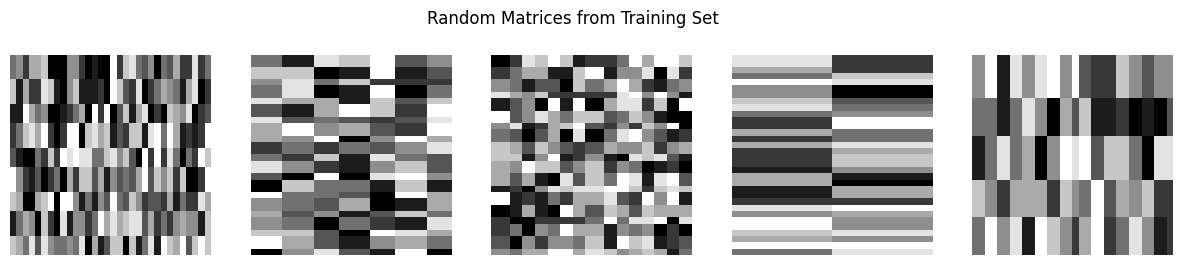

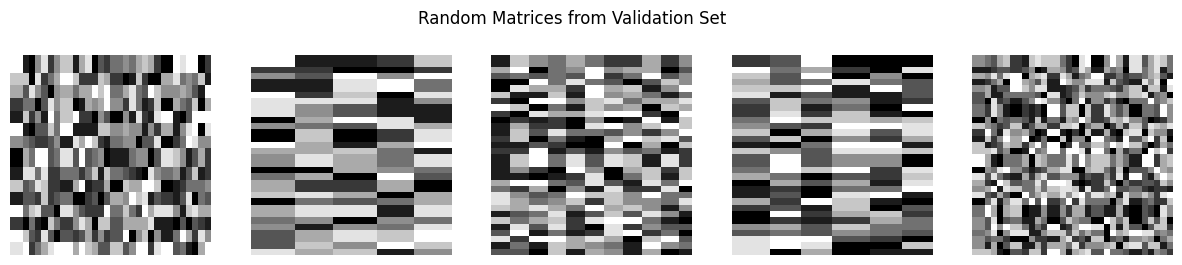

In [ ]:
# Выводим несколько случайных матриц из тренировочного и валидационного наборов
import matplotlib.pyplot as plt

def plot_random_matrices(data, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)
    for i in range(5):
        random_idx = np.random.randint(0, len(data))
        axs[i].imshow(data[random_idx][0], cmap='gray')
        axs[i].axis('off')
    plt.show()

# Выводим случайные матрицы из тренировочного набора
plot_random_matrices(train_data, "Random Matrices from Training Set")

# Выводим случайные матрицы из валидационного набора
plot_random_matrices(val_data, "Random Matrices from Validation Set")


In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU доступен")
else:
    print("GPU НЕ доступен")

GPU доступен


Исходная форма train_data: (160000, 32, 32, 1)
Исходная форма val_data: (40000, 32, 32, 1)
Удаление лишних измерений из train_data...
Форма train_data после squeeze: (160000, 32, 32)
Удаление лишних измерений из val_data...
Форма val_data после squeeze: (40000, 32, 32)
Форма train_data после добавления канала: (160000, 32, 32, 1)
Форма val_data после добавления канала: (40000, 32, 32, 1)
Форма train_data перед fit: (160000, 32, 32, 1)
Форма val_data перед fit: (40000, 32, 32, 1)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_39 (UpSampling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 4, 4, 256)      │       590,08

 Total params: 1,894,913 (7.23 MB)

 Trainable params: 1,892,993 (7.22 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 0.0534 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0017 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0011 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0010 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 9/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0

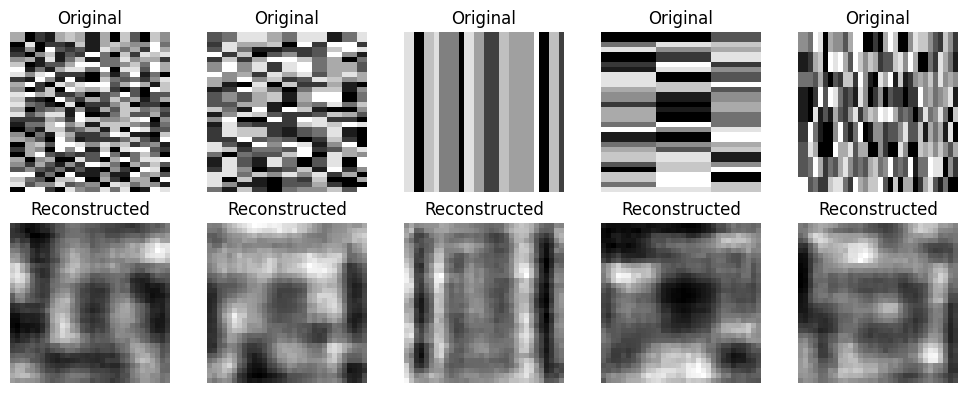

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 9.7444e-04 - val_loss: 9.5576e-04 - learning_rate: 1.0000e-04
Epoch 11/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 9.4752e-04 - val_loss: 9.3043e-04 - learning_rate: 1.0000e-04
Epoch 12/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 9.2071e-04 - val_loss: 9.0548e-04 - learning_rate: 1.0000e-04
Epoch 13/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 8.9340e-04 - val_loss: 8.7727e-04 - learning_rate: 1.0000e-04
Epoch 14/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 8.6728e-04 - val_loss: 8.5053e-04 - learning_rate: 1.0000e-04
Epoch 15/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 8.4409e-04 - val_loss: 8.3253e-04 - learning_rate: 1.0000e-04
Epoch 16/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 8.2539e-04 - val_loss: 8.1689e-04 - learning_rate: 1.0000e-04
Epoch 17/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 8.1073e-04 - val_loss: 8.0314e-04 - learning_rate: 1.0000e-04
Epoch

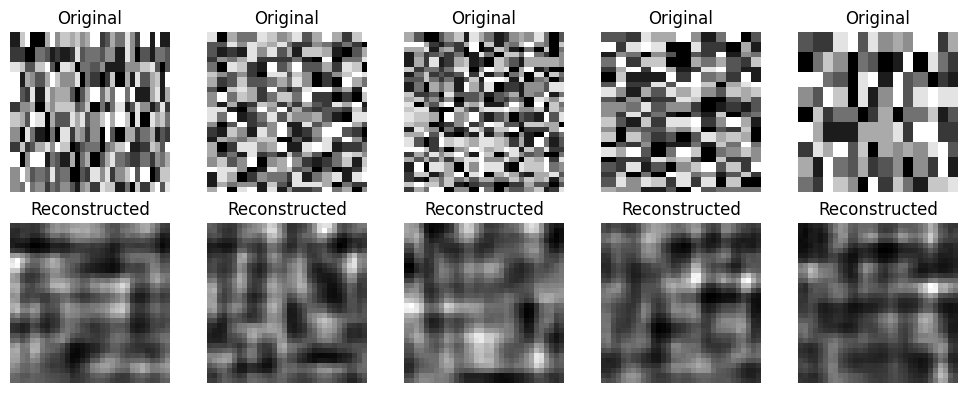

625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 7.8119e-04 - val_loss: 7.7879e-04 - learning_rate: 1.0000e-04
Epoch 21/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.7530e-04 - val_loss: 7.7464e-04 - learning_rate: 1.0000e-04
Epoch 22/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.7112e-04 - val_loss: 7.7127e-04 - learning_rate: 1.0000e-04
Epoch 23/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.6796e-04 - val_loss: 7.6895e-04 - learning_rate: 1.0000e-04
Epoch 24/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.6543e-04 - val_loss: 7.6690e-04 - learning_rate: 1.0000e-04
Epoch 25/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.6335e-04 - val_loss: 7.6465e-04 - learning_rate: 1.0000e-04
Epoch 26/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.6153e-04 - val_loss: 7.6251e-04 - learning_rate: 1.0000e-04
Epoch 27/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.5979e-04 - val_loss: 7.6053e-04 - learning_rate: 1.0000e-04
Epoch

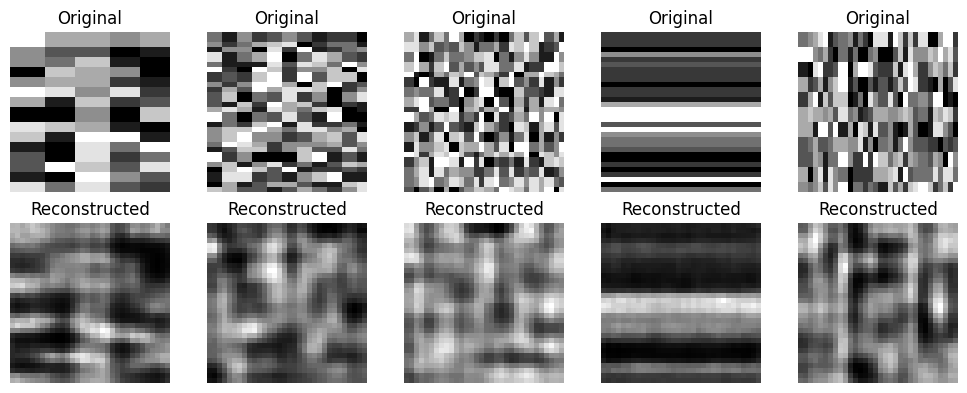

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.5515e-04 - val_loss: 7.5911e-04 - learning_rate: 1.0000e-04
Epoch 31/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.5361e-04 - val_loss: 7.5783e-04 - learning_rate: 1.0000e-04
Epoch 32/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.5185e-04 - val_loss: 7.5608e-04 - learning_rate: 1.0000e-04
Epoch 33/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.5017e-04 - val_loss: 7.5443e-04 - learning_rate: 1.0000e-04
Epoch 34/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.4880e-04 - val_loss: 7.5296e-04 - learning_rate: 1.0000e-04
Epoch 35/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.4754e-04 - val_loss: 7.5209e-04 - learning_rate: 1.0000e-04
Epoch 36/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.4644e-04 - val_loss: 7.5060e-04 - learning_rate: 1.0000e-04
Epoch 37/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.4545e-04 - val_loss: 7.4980e-04 - learning_rate: 1.0000e-04
Epoch

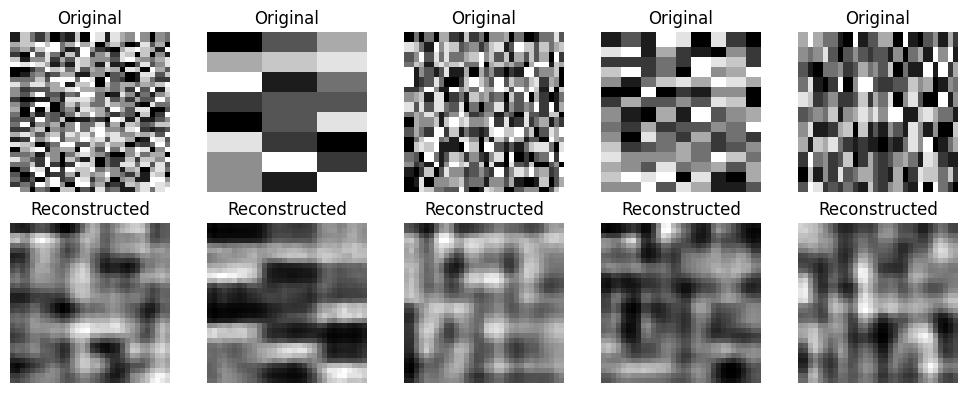

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.4291e-04 - val_loss: 7.4739e-04 - learning_rate: 1.0000e-04
Epoch 41/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.4219e-04 - val_loss: 7.4653e-04 - learning_rate: 1.0000e-04
Epoch 42/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.4152e-04 - val_loss: 7.4587e-04 - learning_rate: 1.0000e-04
Epoch 43/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.4090e-04 - val_loss: 7.4491e-04 - learning_rate: 1.0000e-04
Epoch 44/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.4031e-04 - val_loss: 7.4396e-04 - learning_rate: 1.0000e-04
Epoch 45/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3974e-04 - val_loss: 7.4333e-04 - learning_rate: 1.0000e-04
Epoch 46/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3922e-04 - val_loss: 7.4247e-04 - learning_rate: 1.0000e-04
Epoch 47/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3872e-04 - val_loss: 7.4181e-04 - learning_rate: 1.0000e-04
Epoch

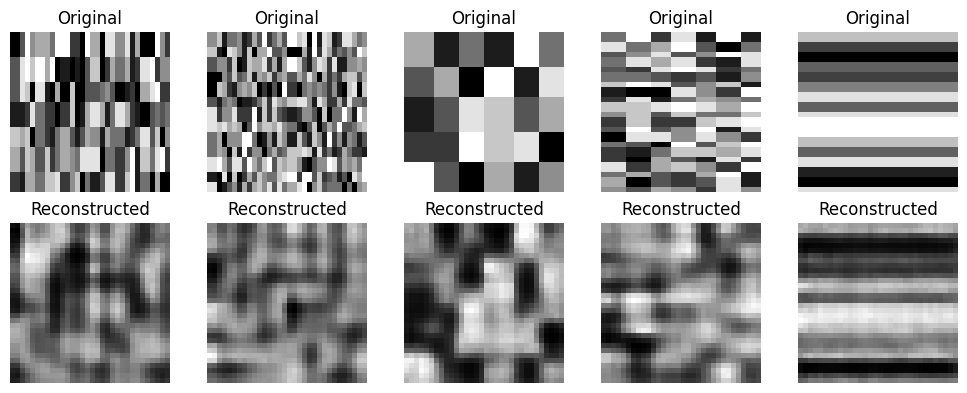

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.3702e-04 - val_loss: 7.3962e-04 - learning_rate: 1.0000e-04
Epoch 51/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3558e-04 - val_loss: 7.3819e-04 - learning_rate: 1.0000e-04
Epoch 52/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3419e-04 - val_loss: 7.3765e-04 - learning_rate: 1.0000e-04
Epoch 53/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3356e-04 - val_loss: 7.3737e-04 - learning_rate: 1.0000e-04
Epoch 54/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3308e-04 - val_loss: 7.3691e-04 - learning_rate: 1.0000e-04
Epoch 55/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3263e-04 - val_loss: 7.3660e-04 - learning_rate: 1.0000e-04
Epoch 56/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3222e-04 - val_loss: 7.3590e-04 - learning_rate: 1.0000e-04
Epoch 57/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3184e-04 - val_loss: 7.3561e-04 - learning_rate: 1.0000e-04
Epoch

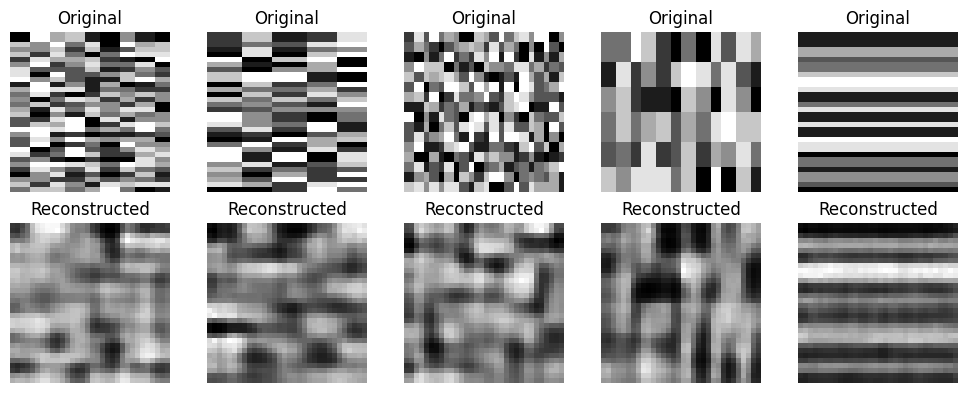

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.3071e-04 - val_loss: 7.3413e-04 - learning_rate: 1.0000e-04
Epoch 61/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.3035e-04 - val_loss: 7.3382e-04 - learning_rate: 1.0000e-04
Epoch 62/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.3007e-04 - val_loss: 7.3335e-04 - learning_rate: 1.0000e-04
Epoch 63/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2969e-04 - val_loss: 7.3291e-04 - learning_rate: 1.0000e-04
Epoch 64/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2935e-04 - val_loss: 7.3258e-04 - learning_rate: 1.0000e-04
Epoch 65/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2902e-04 - val_loss: 7.3224e-04 - learning_rate: 1.0000e-04
Epoch 66/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2875e-04 - val_loss: 7.3184e-04 - learning_rate: 1.0000e-04
Epoch 67/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2844e-04 - val_loss: 7.3164e-04 - learning_rate: 1.0000e-04
Epoch

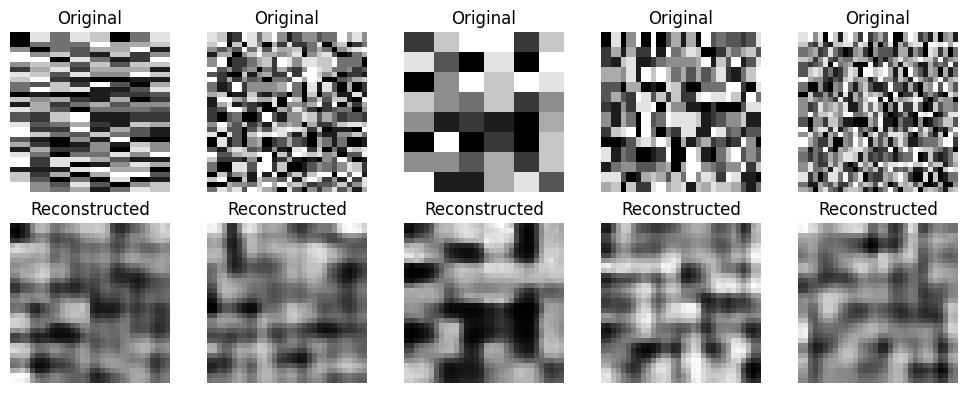

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.2758e-04 - val_loss: 7.3089e-04 - learning_rate: 1.0000e-04
Epoch 71/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2731e-04 - val_loss: 7.3078e-04 - learning_rate: 1.0000e-04
Epoch 72/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.2705e-04 - val_loss: 7.3055e-04 - learning_rate: 1.0000e-04
Epoch 73/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.2678e-04 - val_loss: 7.3047e-04 - learning_rate: 1.0000e-04
Epoch 74/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.2652e-04 - val_loss: 7.3021e-04 - learning_rate: 1.0000e-04
Epoch 75/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2626e-04 - val_loss: 7.3010e-04 - learning_rate: 1.0000e-04
Epoch 76/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2601e-04 - val_loss: 7.3014e-04 - learning_rate: 1.0000e-04
Epoch 77/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2576e-04 - val_loss: 7.2971e-04 - learning_rate: 1.0000e-04
Epoch

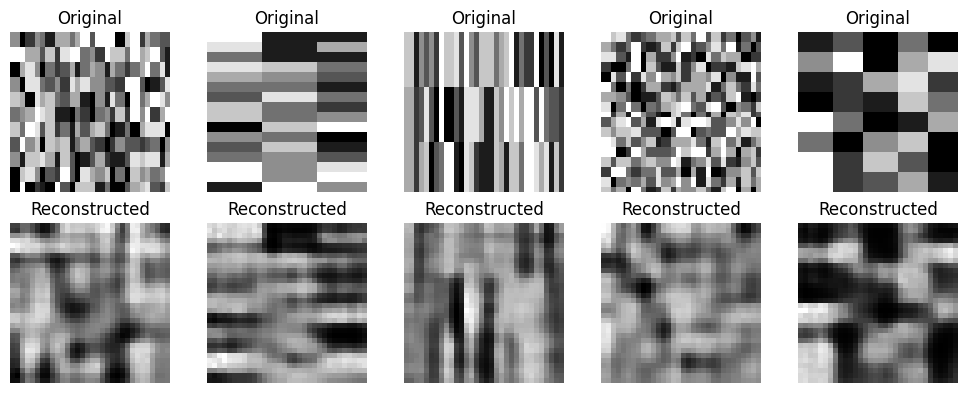

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.2504e-04 - val_loss: 7.2931e-04 - learning_rate: 1.0000e-04
Epoch 81/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2480e-04 - val_loss: 7.2894e-04 - learning_rate: 1.0000e-04
Epoch 82/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.2460e-04 - val_loss: 7.2876e-04 - learning_rate: 1.0000e-04
Epoch 83/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2435e-04 - val_loss: 7.2847e-04 - learning_rate: 1.0000e-04
Epoch 84/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2412e-04 - val_loss: 7.2811e-04 - learning_rate: 1.0000e-04
Epoch 85/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2389e-04 - val_loss: 7.2815e-04 - learning_rate: 1.0000e-04
Epoch 86/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2369e-04 - val_loss: 7.2786e-04 - learning_rate: 1.0000e-04
Epoch 87/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2346e-04 - val_loss: 7.2765e-04 - learning_rate: 1.0000e-04
Epoch

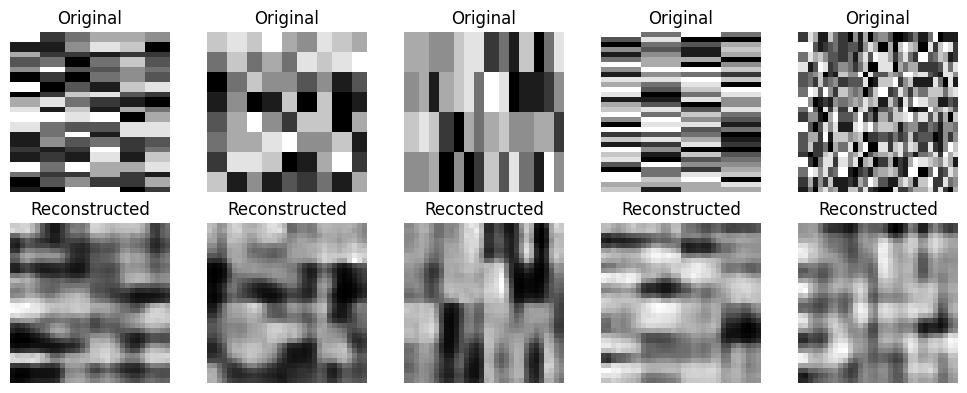

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.2280e-04 - val_loss: 7.2716e-04 - learning_rate: 1.0000e-04
Epoch 91/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2258e-04 - val_loss: 7.2690e-04 - learning_rate: 1.0000e-04
Epoch 92/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2236e-04 - val_loss: 7.2686e-04 - learning_rate: 1.0000e-04
Epoch 93/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2214e-04 - val_loss: 7.2674e-04 - learning_rate: 1.0000e-04
Epoch 94/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2192e-04 - val_loss: 7.2649e-04 - learning_rate: 1.0000e-04
Epoch 95/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2171e-04 - val_loss: 7.2625e-04 - learning_rate: 1.0000e-04
Epoch 96/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2153e-04 - val_loss: 7.2615e-04 - learning_rate: 1.0000e-04
Epoch 97/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2128e-04 - val_loss: 7.2609e-04 - learning_rate: 1.0000e-04
Epoch

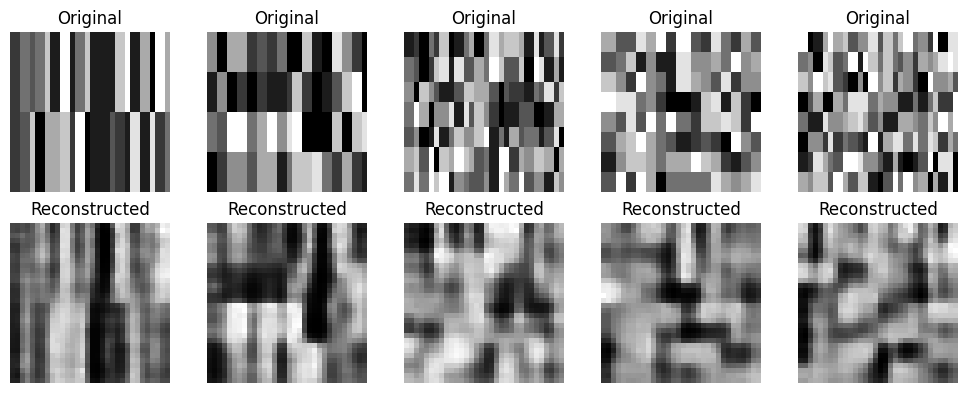

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.2063e-04 - val_loss: 7.2571e-04 - learning_rate: 1.0000e-04


In [ ]:
# ============================================
# Шаг 0: Установка и Импорт Необходимых Библиотек
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Flatten, Dense, Reshape, BatchNormalization, LeakyReLU, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, TensorBoard

# Включение миксированной точности (если поддерживается GPU)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ============================================
# Шаг 1: Настройка Параметров Обучения
# ============================================

# Параметры модели
input_shape = (32, 32, 1)      # Форма входных данных
embedding_dim = 256            # Размер эмбеддинга

# Параметры обучения
batch_size = 256               # Размер батча
epochs = 100                 # Общее количество эпох
learning_rate = 1e-4           # Уменьшенная скорость обучения

# Параметры колбэков
display_freq = 10              # Частота отображения графиков (в эпохах)
num_display_images = 5         # Количество изображений для отображения

# ============================================
# Шаг 2: Подготовка Данных
# ============================================

# Предполагается, что train_data и val_data уже загружены как numpy массивы формы (num_samples, 32, 32)
# Пример загрузки данных:
# train_data = np.load('path_to_train_data.npy')
# val_data = np.load('path_to_val_data.npy')

# Проверка исходной формы данных
print("Исходная форма train_data:", train_data.shape)
print("Исходная форма val_data:", val_data.shape)

# Удаление лишних измерений, если они есть
def preprocess_data(data, name='data'):
    if len(data.shape) > 3:
        print(f"Удаление лишних измерений из {name}...")
        data = np.squeeze(data)
        print(f"Форма {name} после squeeze:", data.shape)
    return data

train_data = preprocess_data(train_data, 'train_data')
val_data = preprocess_data(val_data, 'val_data')

# Нормализация данных до диапазона [0, 1]
train_data = train_data.astype('float32') / 9.0
val_data = val_data.astype('float32') / 9.0

# Добавление канала, чтобы данные имели форму (num_samples, 32, 32, 1)
def add_channel(data, name='data'):
    if len(data.shape) == 2:
        # Если данные имеют форму (32, 32), добавляем размерность канала
        data = np.expand_dims(data, axis=-1)
        print(f"Форма {name} после добавления канала:", data.shape)
    elif len(data.shape) == 3 and data.shape[-1] != 1:
        # Если данные имеют форму (num_samples, 32, 32) без канала, добавляем канал
        data = np.expand_dims(data, axis=-1)
        print(f"Форма {name} после добавления канала:", data.shape)
    return data

train_data = add_channel(train_data, 'train_data')
val_data = add_channel(val_data, 'val_data')

# Финальная проверка формы данных
print("Форма train_data перед fit:", train_data.shape)
print("Форма val_data перед fit:", val_data.shape)

# ============================================
# Шаг 3: Построение Модели Автоэнкодера
# ============================================

def build_autoencoder(input_shape, embedding_dim=256):
    input_img = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Дополнительный свёрточный слой
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Бутылочное горлышко
    x = Flatten()(x)
    encoded = Dense(embedding_dim, activation='relu')(x)

    # Декодер
    x = Dense(2 * 2 * 256, activation='relu')(encoded)
    x = Reshape((2, 2, 256))(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)

    # Выходной слой
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Модель
    autoencoder = Model(inputs=input_img, outputs=decoded)
    return autoencoder

# Инициализация модели
autoencoder = build_autoencoder(input_shape, embedding_dim=embedding_dim)

# ============================================
# Шаг 4: Компиляция Модели
# ============================================

optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

autoencoder.summary()

# ============================================
# Шаг 5: Настройка Колбэков
# ============================================

# Колбэк для отображения результатов каждые display_freq эпох
class ImageDisplayCallback(Callback):
    def __init__(self, val_data, display_freq=10, num_images=5):
        super(ImageDisplayCallback, self).__init__()
        self.val_data = val_data
        self.display_freq = display_freq
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_freq == 0:
            idx = np.random.randint(0, self.val_data.shape[0], size=self.num_images)
            sample_images = self.val_data[idx]
            reconstructed = self.model.predict(sample_images)

            plt.figure(figsize=(10, 4))
            for i in range(self.num_images):
                # Оригинальные изображения
                ax = plt.subplot(2, self.num_images, i + 1)
                plt.imshow(sample_images[i].reshape(32, 32), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                # Восстановленные изображения
                ax = plt.subplot(2, self.num_images, i + 1 + self.num_images)
                plt.imshow(reconstructed[i].reshape(32, 32), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
            plt.tight_layout()
            plt.show()

# Планировщик скорости обучения: уменьшение lr после 500 эпох
def scheduler(epoch, lr):
    if epoch > 500:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

# TensorBoard для мониторинга обучения
tensorboard = TensorBoard(log_dir='/kaggle/working/logs')

# Инициализация пользовательских колбэков
image_display = ImageDisplayCallback(val_data=val_data, display_freq=display_freq, num_images=num_display_images)
callbacks = [image_display, lr_scheduler, tensorboard]

# ============================================
# Шаг 6: Создание Потока Данных с Использованием tf.data.Dataset
# ============================================

# Создание Dataset для обучения
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Создание Dataset для валидации
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data))
val_dataset = val_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# ============================================
# Шаг 7: Обучение Модели
# ============================================

autoencoder.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks
)

# ============================================
# Шаг 8: Сохранение и Загрузка Модели
# ============================================

# Функция для сохранения модели вручную (опционально)
def save_model_manual(model, save_dir='/kaggle/working/saved_models/'):
    os.makedirs(save_dir, exist_ok=True)  # Создание директории, если не существует
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'autoencoder_{timestamp}.keras'
    filepath = os.path.join(save_dir, filename)
    model.save(filepath)
    print(f'Модель сохранена по пути: {filepath}')

# Функция для загрузки сохранённой модели
def load_saved_model(filepath):
    if os.path.exists(filepath):
        model = load_model(filepath)
        print(f'Модель загружена из: {filepath}')
        return model
    else:
        print(f'Файл модели не найден по пути: {filepath}')
        return None

# ============================================
# Шаг 9: Визуализация Сохранённых Моделей (Опционально)
# ============================================

# Функция для визуализации всех сохранённых моделей
def visualize_saved_models(save_dir='/kaggle/working/saved_models/', num_images=5):
    if not os.path.exists(save_dir):
        print(f"Директория {save_dir} не существует.")
        return

    saved_files = sorted([f for f in os.listdir(save_dir) if f.startswith('autoencoder_') and f.endswith('.keras')])
    if not saved_files:
        print(f"В директории {save_dir} нет сохранённых моделей.")
        return

    for file in saved_files:
        filepath = os.path.join(save_dir, file)
        model = load_saved_model(filepath)
        if model:
            print(f'Визуализация модели из файла: {file}')
            idx = np.random.randint(0, val_data.shape[0], size=num_images)
            sample_images = val_data[idx]
            reconstructed = model.predict(sample_images)

            plt.figure(figsize=(10, 4))
            for i in range(num_images):
                # Оригинальные изображения
                ax = plt.subplot(2, num_images, i + 1)
                plt.imshow(sample_images[i].reshape(32, 32), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                # Восстановленные изображения
                ax = plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(reconstructed[i].reshape(32, 32), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
            plt.tight_layout()
            plt.show()

# Пример использования функции визуализации (можно вызвать после обучения)
# visualize_saved_models()


In [ ]:
from tensorflow.keras.models import save_model
from datetime import datetime

# Функция для сохранения модели вручную с временной меткой
def save_model_manual(model, save_dir='/kaggle/working/'):
    os.makedirs(save_dir, exist_ok=True)  # Создание директории, если не существует
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'autoencoder_{timestamp}.keras'
    filepath = os.path.join(save_dir, filename)
    model.save(filepath)
    print(f'Модель сохранена по пути: {filepath}')

# Пример сохранения модели
save_model_manual(autoencoder)


Модель сохранена по пути: /kaggle/working/autoencoder_20241024_202957.keras


In [ ]:
from tensorflow.keras.models import load_model

# Функция для загрузки сохранённой модели
def load_saved_model(filepath):
    if os.path.exists(filepath):
        model = load_model(filepath)
        print(f'Модель загружена из: {filepath}')
        return model
    else:
        print(f'Файл модели не найден по пути: {filepath}')
        return None

# Пример загрузки модели
# Замените 'path_to_model.keras' на путь к вашей сохранённой модели
loaded_autoencoder = load_saved_model('/kaggle/working/saved_models/autoencoder_20230425_123456.keras')

# Если вы планируете продолжить обучение, перекомпилируйте модель
if loaded_autoencoder:
    loaded_autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')


In [ ]:
if loaded_autoencoder:
    additional_epochs = 50          # Дополнительные эпохи для обучения
    initial_epoch = epochs           # Предыдущее количество эпох

    loaded_autoencoder.fit(
        train_dataset,
        epochs=initial_epoch + additional_epochs,
        initial_epoch=initial_epoch,
        validation_data=val_dataset,
        callbacks=callbacks
    )
